# Swarms

In Underworld, the swarm is an object that defines a collection of particles. Swarms are usually used to track the Lagrangian quantities required for a given model, such as a material type identifier, or the plastic strain of an advecting parcel of fluid. Swarm may be used passively to record information as they advect, or actively where the values recorded on particles actually feed into rheologies or forces. 

Swarms of particles may:

1. Advect through the mesh according to a user specified velocity.
1. Store arbitrary data on a per-particle basis.
1. Freely cross process boundaries in parallel simulations.

The user is free to create as many swarms as required and each swarm may contain an arbitrary number of particles. The *data layout* for any given swarm is identical across all its particles, though different swarms may have different layouts. For example, *SwarmA* may contain 100 particles, and each particle may encode an `int` and a `float`, while *SwarmB* may contain 15 particles, each particle encoding three `float` values. Particles may also be added to a swarm at any stage either directly or through population control mechanisms. It is also possible to delete particles, though currently this is only possible through indirect means.


#### Overview
1. Creating a swarm object and adding particles.
1. Moving particles.
1. Swarm variables.
1. Shapes with particle swarms.
1. Saving and loading swarms.


**Keywords:** swarms, particles, shapes.


## Creating a swarm object and adding particles

Creating a swarm is very simple. You will first require a mesh, as the mesh object is used to determine domain and parallel decomposition of your model. 

In [1]:
import underworld as uw
import glucifer
import numpy as np

mesh = uw.mesh.FeMesh_Cartesian(maxCoord=(2.,1.))

swarm = uw.swarm.Swarm( mesh=mesh )

Once you have created your swarm, you can then add particles. To add particles, you will either use a *layout* object, or generate a numpy array with the required particle coordinates. Let's first look at using layouts:


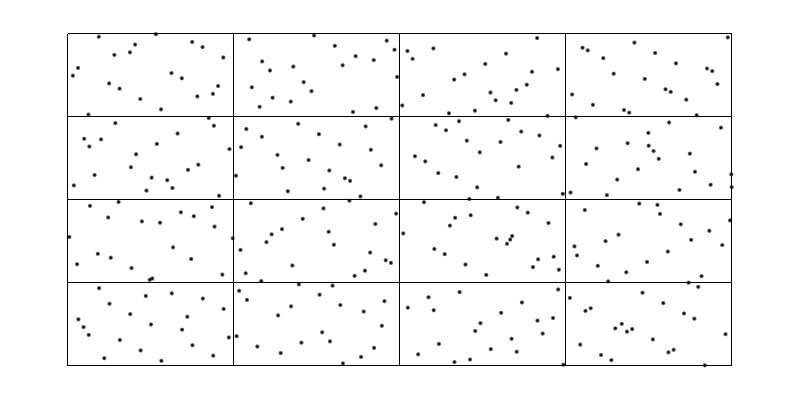

In [2]:
swarmLayout = uw.swarm.layouts.PerCellSpaceFillerLayout( swarm=swarm, particlesPerCell=20 )

# perform the populating
swarm.populate_using_layout( layout=swarmLayout )

# vis
fig = glucifer.Figure(figsize=(800,400))
fig.append( glucifer.objects.Points(swarm=swarm, pointSize=5, colourBar=False) )
fig.append( glucifer.objects.Mesh(mesh) )
fig.show()

Layouts are usually the best option where you want to populate the entire domain with particles. This is the usual use case where you intend on using particles dynamically. Note also that layouts may only be used to populate swarm objects which are currently empty. There are numerous layouts available in the `underworld.swarm.layouts` submodule.

Swarms can also be populated using numpy arrays that specify particle coordinates. This is how you will add particles when you wish to explicitly specify their coordinates and the total number of particles. The usual use case for this is adding passive swarms for analytic purposes, such as tracking interfaces, or extracting data at fixed coordinates throughout your simulations. 

Let's create a new swarm and add particles explicitly.

In [3]:
swarmCustom = uw.swarm.Swarm( mesh=mesh, particleEscape=True )

# create the array
swarmCoords = np.array([ [0.4,0.2], [0.8,0.4],[1.2,0.6],[1.6,0.8],[3.6,1.8]])

# use the array to add particles at the specified coordinates.
swarmCustom.add_particles_with_coordinates(swarmCoords)

array([ 0,  1,  2,  3, -1], dtype=int32)

Note the array returned above by the `add_particles_with_coordinates` method. It specifies the local identifiers for the added particles. Coordinates which are not within the (local) domain will be ignored and are signified with a `-1`. For parallel simulation, the domain is partitioned across all processes, and therefore coordinates which are ignored on one process (ie, no particle created) may be consumed on another process (ie, particle created).

Let's have a look at our new swarm.


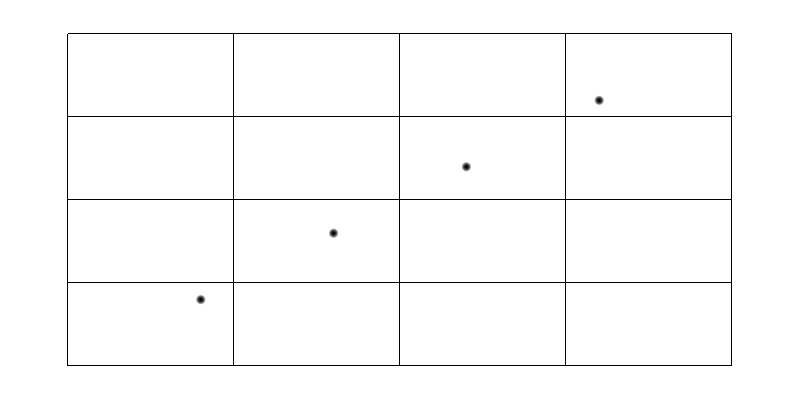

In [4]:
fig = glucifer.Figure(figsize=(800,400))
fig.append( glucifer.objects.Points(swarm=swarmCustom, pointSize=10, colourBar=False) )
fig.append( glucifer.objects.Mesh(mesh))
fig.show()

## Moving particles

To move particles, you have two options. You can explicitly move particles using the `data` numpy array on the swarm (or equivalently via `particleCoordinates.data`), or you can use the swarm advector object (`underworld.Systems.SwarmAdvector`). The latter is a natural choice when advecting a swarm with a velocity field that you have either defined, or is the result of a Stokes solve. It is the usual way in which particles are advected.

Let us start with a very basic constant velocity field with which to advect particles


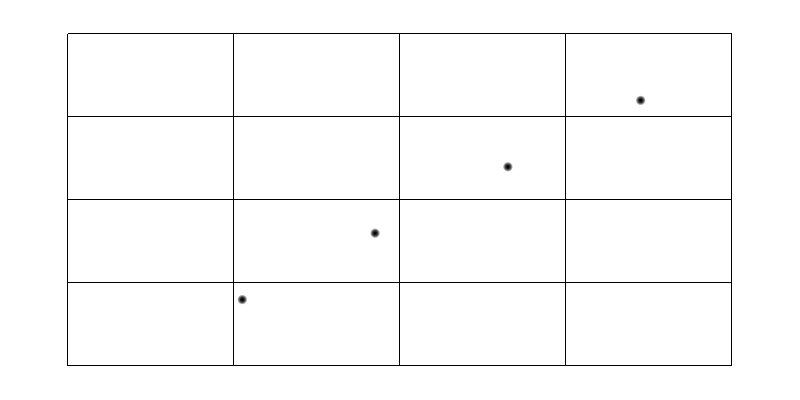

In [5]:
vel = mesh.add_variable(2)
vel.data[:] = (1.,0.)

advector = uw.systems.SwarmAdvector(vel,swarmCustom)
dt = advector.get_max_dt()
advector.integrate(dt)
fig.show()

Note that the swarm advector requires a `MeshVariable` class velocity field object, and does not yet support the more general `Function` class.

To modify particle coordinates directly, we must use the `deform_swarm` context manager, much as the `deform_mesh` manager is required to modify the mesh.  We will first move a single particle:


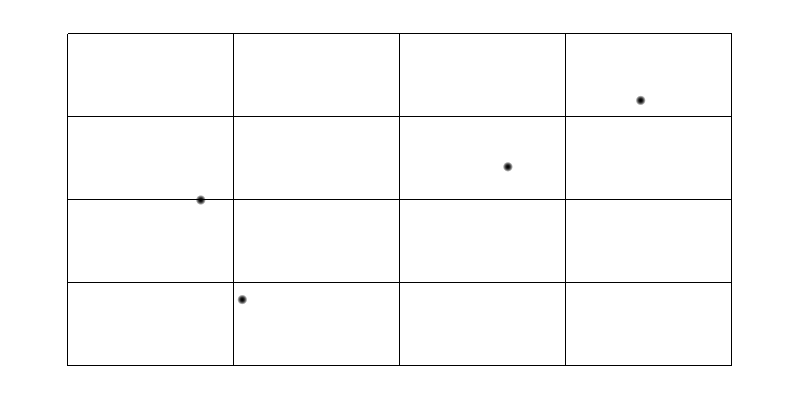

In [6]:
with swarmCustom.deform_swarm():
    swarmCustom.data[1] = (0.4,0.5)
    
fig.show()

Underworld also supports particle deletion, though currently this is only possible by moving particles outside the domain. Note that the swarm object must also be created with `particleEscape=True`.


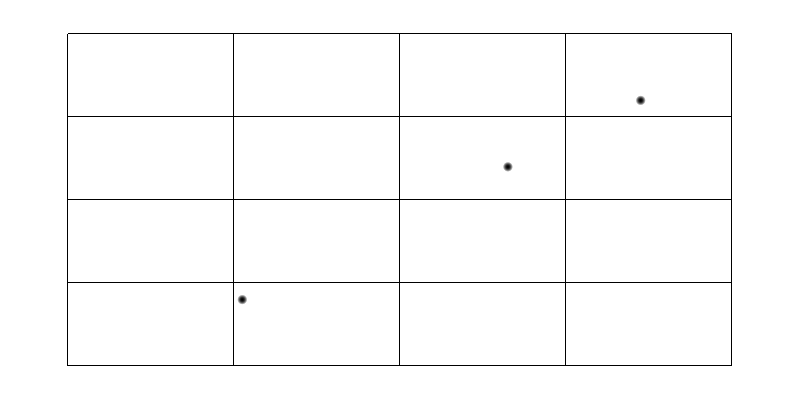

In [7]:
with swarmCustom.deform_swarm():
    swarmCustom.data[1] = (9999,9999.)

fig.show()

## Swarm variables

You may add data storing variables to the swarm via the `add_variable()` swarm method. Each particle will record a value of the given type and count:


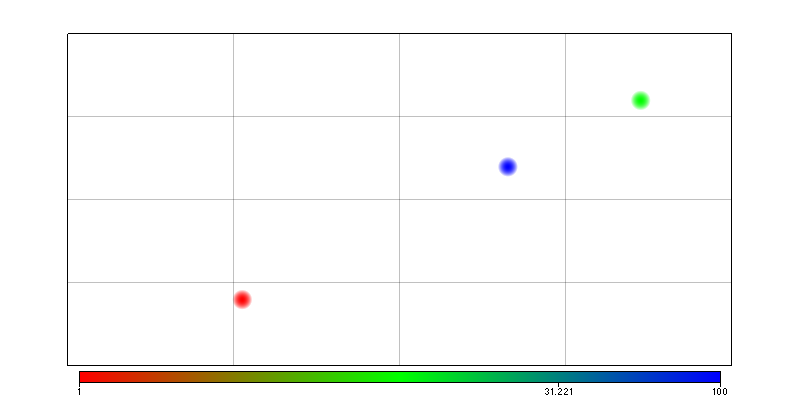

In [8]:
swarmVariable = swarmCustom.add_variable(dataType='double', count=1)
swarmVariable.data[0] = 1.
swarmVariable.data[1] = 10.
swarmVariable.data[2] = 100.

fig = glucifer.Figure(figsize=(800,400))
fig.append( glucifer.objects.Points( swarm=swarmCustom, pointSize=20, 
                                      fn_colour=swarmVariable, colourBar = True,
                                      colours="red green blue", logScale=True) )
fig.append( glucifer.objects.Mesh(mesh, opacity=0.25))
fig.show()

## Shapes with particle swarms

This example will demonstrate the creation of geometry using swarm variables. Particle geometries often form means to define initial fluid/material distribution in models. You will see later how once you have defined a material identifier on each particle, you can then delegate different behaviours based on this identifier using `Function` objects.

First we'll create a vanilla swarm with a `materialIndex` variable to record the material type:


In [9]:
mesh = uw.mesh.FeMesh_Cartesian( elementRes  = (64, 64), 
                                 maxCoord    = (2., 1.) )
swarm = uw.swarm.Swarm( mesh=mesh )

# add a data variable which will store an index to determine material
materialIndex = swarm.add_variable( dataType="int", count=1 )

# populate our swarm across the mesh domain
swarmLayout = uw.swarm.layouts.PerCellSpaceFillerLayout( swarm=swarm, particlesPerCell=20 )
swarm.populate_using_layout( layout=swarmLayout )
materialIndex.data[:] = 0 

We want to configure our `materialIndex` such that it *defines* a circle. We will use a Python loop to traverse all the particles, and for particles who's coordinates fall inside our circle shape, we will set their `materialIndex` value to `1`. Note that we have already initialised the `materialIndex` values to `0` above, so we only need to modify the values of particles within the circle. 


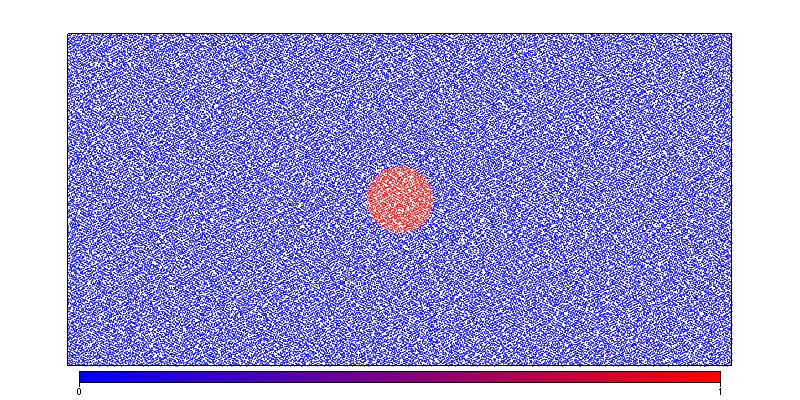

In [10]:
# our circles parameters
circleRadius = 0.1
circleCentre = (1., 0.5)

# the particle loop
for index, coord in enumerate(swarm.particleCoordinates.data):
    x = coord[0]
    z = coord[1]
    xx = x - circleCentre[0]
    zz = z - circleCentre[1]
    condition = (xx*xx + zz*zz < circleRadius**2)
    if(condition == True):  # inside the circle
        materialIndex.data[index] = 1

# vis
fig = glucifer.Figure(figsize=(800,400))
fig.append( glucifer.objects.Points( swarm=swarm, fn_colour=materialIndex, colours='blue red', 
                               colourBar=True, pointSize=2.0 ) )
fig.show()

More efficient ways to achieve this are presented in the **Functions** section of the user guide, though for operations that are usually only performed once in a simulation (such as initialisation), we recommend using whichever method you find most natural, as the costs are usually negligible.

## Saving and load a swarms and swarm variables

As with other data types, the `save()` method is used to save `Swarm` and `SwarmVariable` objects. 

In [11]:
ignore = swarm.save("SwarmWithCircle.h5")
ignore = materialIndex.save("SwarmWithCircle.materialIndex.h5")

Note that the above methods return `SavedFileData` objects which are used required if you wish to create XDMF files and can be ignored otherwise. Although it is not necessary to do so, we record them to the `ignore` instance as they are not required here. See the **Utilities** section of the user guide for further information. 

Similarly, the `load()` method is used to load `Swarm` and `SwarmVariable` objects. Note that it is necessary to load the `Swarm` object before the corresponding `SwarmVariable` object can be loaded. Ie, you cannot load directly onto an existing `SwarmVariable` without first loading a `Swarm`.  This is to ensure that both objects are in a compatible state (specifically, the correct number of particles exists **and** the data ordering is identical).


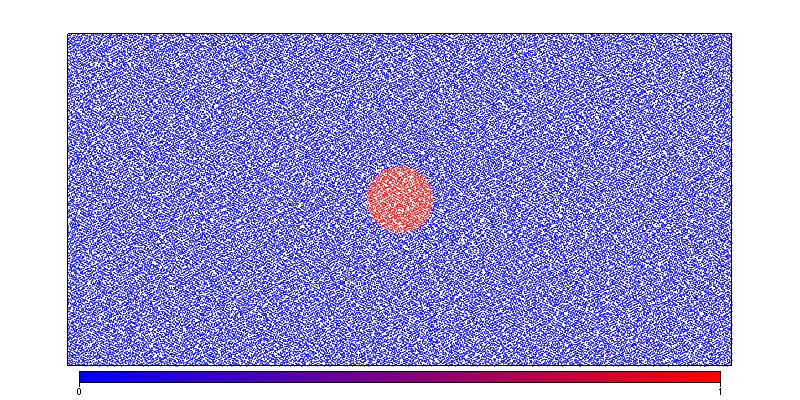

In [12]:
swarmCopy = uw.swarm.Swarm( mesh=mesh )
swarmCopy.load("SwarmWithCircle.h5")

# The swarm geometry is now loaded but the swarmVariables are not restored.
# We have to explicitly create and re-populate any variables we have previously saved

materialIndexCopy = swarmCopy.add_variable("int",1)
materialIndexCopy.load("SwarmWithCircle.materialIndex.h5")

fig = glucifer.Figure(figsize=(800,400))
fig.append( glucifer.objects.Points( swarm=swarmCopy, fn_colour=materialIndexCopy, colours='blue red', 
                                      colourBar=True, pointSize=2.0 ) )
fig.show()

In [13]:
# Cleanup
if uw.rank()==0:
    import os
    os.remove( "SwarmWithCircle.h5" )
    os.remove( "SwarmWithCircle.materialIndex.h5" )